In [1]:
#Import of some of the required libraries
import numpy as np
import io
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as Soup
import pandas as pd
import hdbscan
from nltk.tokenize import RegexpTokenizer

#this awesome library reduces cluttering of text-labels on points
#https://github.com/Phlya/adjustText
from adjustText import adjust_text
%matplotlib inline

In [2]:
#Parse the document as xml as specified in the original article
map_coords="doc.kml"
data = io.open(map_coords, mode="r", encoding="utf-8")

kml=Soup(data,'lxml-xml')
#Store the coors in coords_list
coords=kml.find_all('coordinates')
coords_list=[]
for c in coords:
    coords_list.append(str(c))
    
#Store the names in names_list
names=kml.find_all('name')
names_list=[]
for n in names:
    names_list.append(str(n)) 

print(coords_list[0])
print(names_list[0])

<coordinates>
            2.28717860000006,48.8629697,0
          </coordinates>
<name>Place du Trocadero</name>


As we can see from the prints above, the cleaning is far from over!
The next cell tokenizes the longitude and latitude and stores them in a numpy array (29x2).

In [3]:
#lat_long is the numpy arrays that contains the lat/long data
tokenizer = RegexpTokenizer('\s+', gaps=True)
treated=[]
for p in coords_list:
    treated.append(tokenizer.tokenize(p))
    treated_2=[]
for i in range (0,len(treated)):
    treated_2.append(treated[i][1])
tokenizer = RegexpTokenizer(',', gaps=True)
lat_long=np.zeros((29,2))
for i in range(0,len(treated_2)):
    lat_long[i][0]=(tokenizer.tokenize(treated_2[i]))[0]
    lat_long[i][1]=(tokenizer.tokenize(treated_2[i]))[1]

print(lat_long[0:3])

[[  2.2871786  48.8629697]
 [  2.3578263  48.8604454]
 [  2.3507857  48.8650948]]


In [4]:
#names is a list that contains the names of the landmarks/touristic places
tokenizer = RegexpTokenizer('>|<', gaps=True)
treated=[]
for p in names_list:
    treated.append(tokenizer.tokenize(p))
names=[]
for i in range (0,len(treated)):
    names.append(treated[i][1])

#df is the data frame that contains each place and its associated latitude and longitude
#df_ct is used to reset df after normalization (more on this later)
d = {'Longitude': lat_long[:,1], 'Latitude': lat_long[:,0],'Place':names}
df = pd.DataFrame(data=d)
df_ct = pd.DataFrame(data=d)

print(names[0:3])
print()
df

['Place du Trocadero', 'Hotel de Soubise', 'Paris-Walks - The Landmarks of Paris tower']



,Latitude,Longitude,Place
0,2.287179,48.862970,Place du Trocadero
1,2.357826,48.860445,Hotel de Soubise
2,2.350786,48.865095,Paris-Walks - The Landmarks of Paris tower
3,2.342508,48.856542,Place Dauphine
4,2.331569,48.872358,Le Lac du Palais Garnier
5,2.329445,48.867473,Colonne Vendôme
6,2.359793,48.850888,Hôtel Lambert
7,2.324336,48.860313,Hotel Salm
8,2.359148,48.853430,Hôtel de Sens
9,2.322857,48.855661,Grand Hotel d'Estrees


The above is a snippet of the dataframe.

# Sklearn's Kmeans

Snippet of dataframe without normlization:
    Latitude  Longitude                                       Place  Cluster
27  2.332422  48.833832                          Catacombs of Paris        0
14  2.322672  48.863788                            Orangerie Museum        1
15  2.315835  48.855307                                Rodin Museum        1
12  2.326561  48.859961                               Musée d'Orsay        1
9   2.322857  48.855661                       Grand Hotel d'Estrees        1
16  2.314590  48.866048                                Petit Palais        1
7   2.324336  48.860313                                  Hotel Salm        1
17  2.310532  48.875448                      Musée Jacquemart-André        1
23  2.321236  48.865633                        Place de la Concorde        1
26  2.349902  48.852968              Cathédrale Notre-Dame de Paris        2
10  2.352245  48.860642                         The Centre Pompidou        2
22  2.344987  48.855420          

500

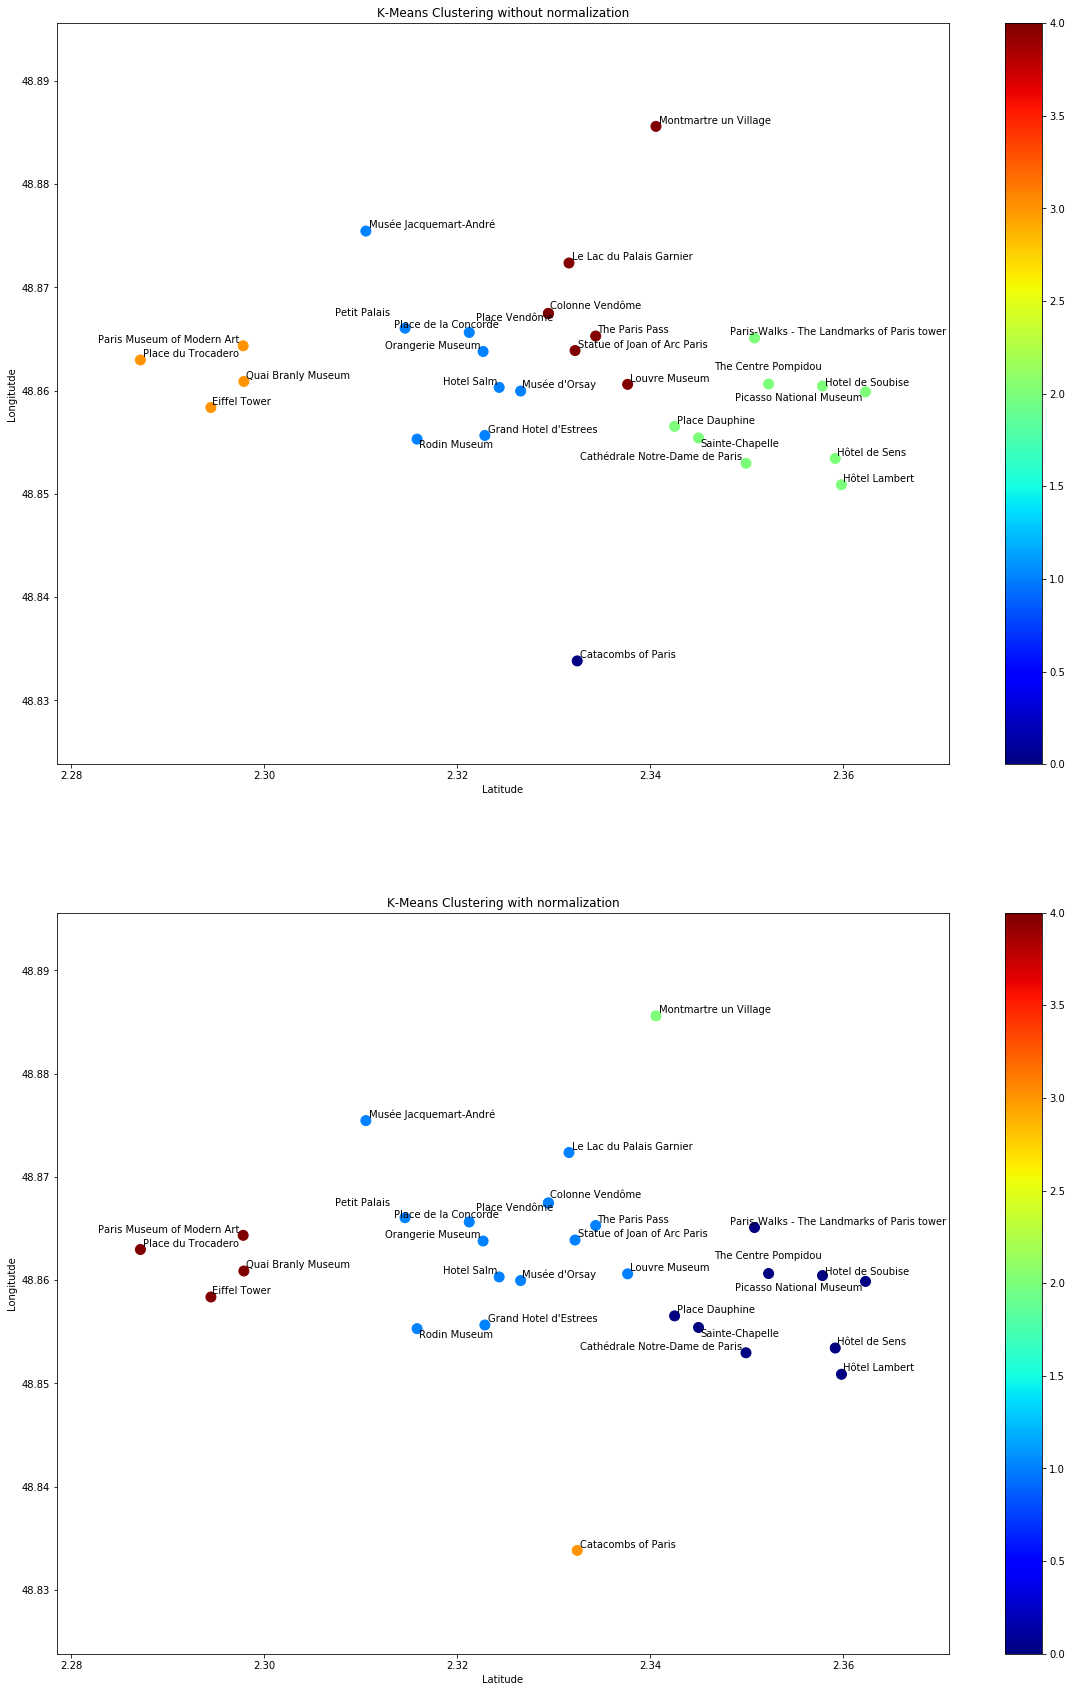

In [5]:
#Sklearn's KMeans with 4 clusters
from sklearn.cluster import KMeans 
kmeans_1 = KMeans(n_clusters=5,n_jobs=-1,n_init = 40)
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(211)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('K-Means Clustering without normalization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']))
print()
 
texts = [ax.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 

df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 
ax1 = fig.add_subplot(212)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('K-Means Clustering with normalization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']))
texts = [ax1.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 



# Analysis of K-means

* Not much difference is observed depending on the intial seeds.
* 2 points are clear noise: Catacombs of Paris, and Montmartre village.
* By setting the number of clusters to 7 instead of 5, we get a better division of the clusters as follows:



![title](7-clusters-kmeans-result.png)

![title](7-clusters.png)

* The clusters are much better like that.

# HDBSCAN's DBSCAN

Snippet of dataframe without normlization:
    Latitude  Longitude                                       Place  Cluster
20  2.340579  48.885587                       Montmartre un Village       -1
17  2.310532  48.875448                      Musée Jacquemart-André       -1
4   2.331569  48.872358                    Le Lac du Palais Garnier       -1
16  2.314590  48.866048                                Petit Palais       -1
15  2.315835  48.855307                                Rodin Museum       -1
27  2.332422  48.833832                          Catacombs of Paris       -1
9   2.322857  48.855661                       Grand Hotel d'Estrees       -1
11  2.337644  48.860611                               Louvre Museum       -1
0   2.287179  48.862970                          Place du Trocadero        0
18  2.297821  48.864342                  Paris Museum of Modern Art        0
13  2.297894  48.860889                          Quai Branly Museum        0
28  2.294481  48.858370          

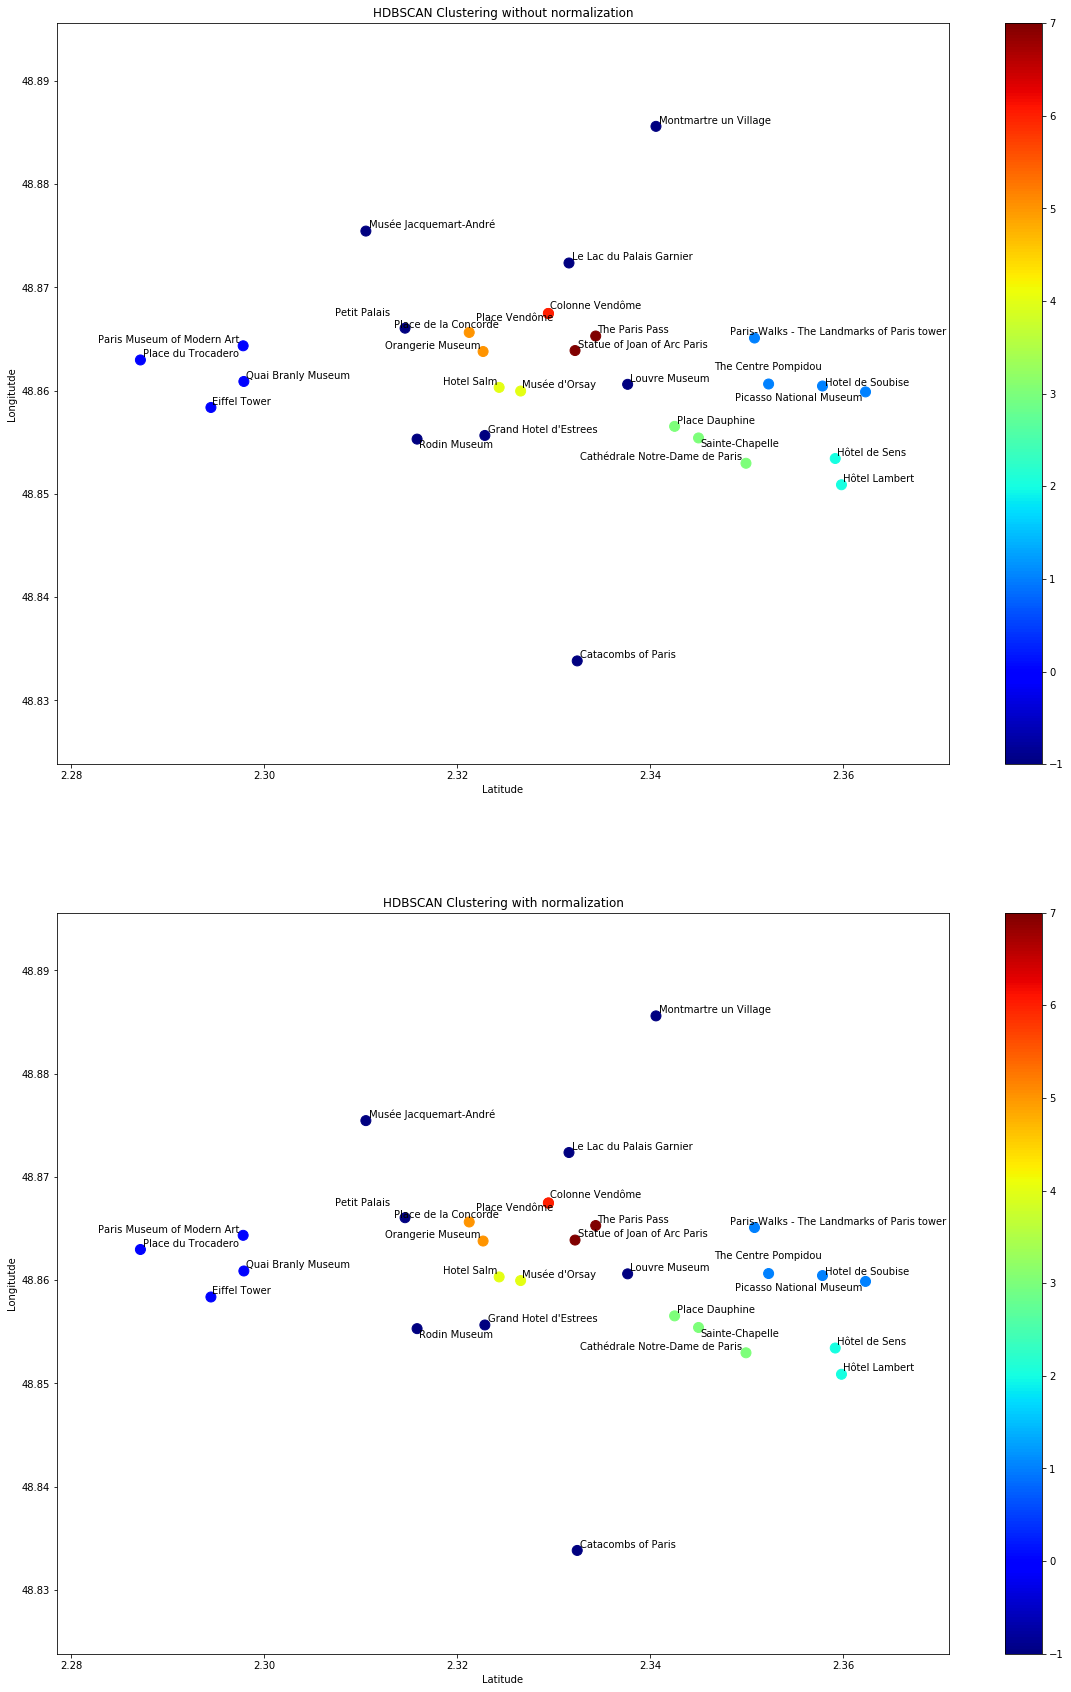

In [6]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
rads = np.radians(X)
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine',core_dist_n_jobs=25)
predictions = clusterer.fit_predict(rads)
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(211)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('HDBSCAN Clustering without normalization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
texts = [ax.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']))
print()
df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = clusterer.fit_predict(X) 
ax1 = fig.add_subplot(212)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('HDBSCAN Clustering with normalization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
texts = [ax1.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']))

# Analysis of HDBSCAN's DBSCAN with harvesine

* No noticeable difference.
* Many points are labeled as noise. DBSCAN focuses on Cohesion. Choose this if you don't want to walk a lot!




# Sklearn's DBSCAN

Snippet of dataframe without normlization:
    Latitude  Longitude                                       Place  Cluster
0   2.287179  48.862970                          Place du Trocadero       -1
17  2.310532  48.875448                      Musée Jacquemart-André       -1
16  2.314590  48.866048                                Petit Palais       -1
15  2.315835  48.855307                                Rodin Museum       -1
27  2.332422  48.833832                          Catacombs of Paris       -1
11  2.337644  48.860611                               Louvre Museum       -1
9   2.322857  48.855661                       Grand Hotel d'Estrees       -1
20  2.340579  48.885587                       Montmartre un Village       -1
4   2.331569  48.872358                    Le Lac du Palais Garnier       -1
26  2.349902  48.852968              Cathédrale Notre-Dame de Paris       -1
19  2.362285  48.859878                     Picasso National Museum        0
2   2.350786  48.865095  Paris-Wa

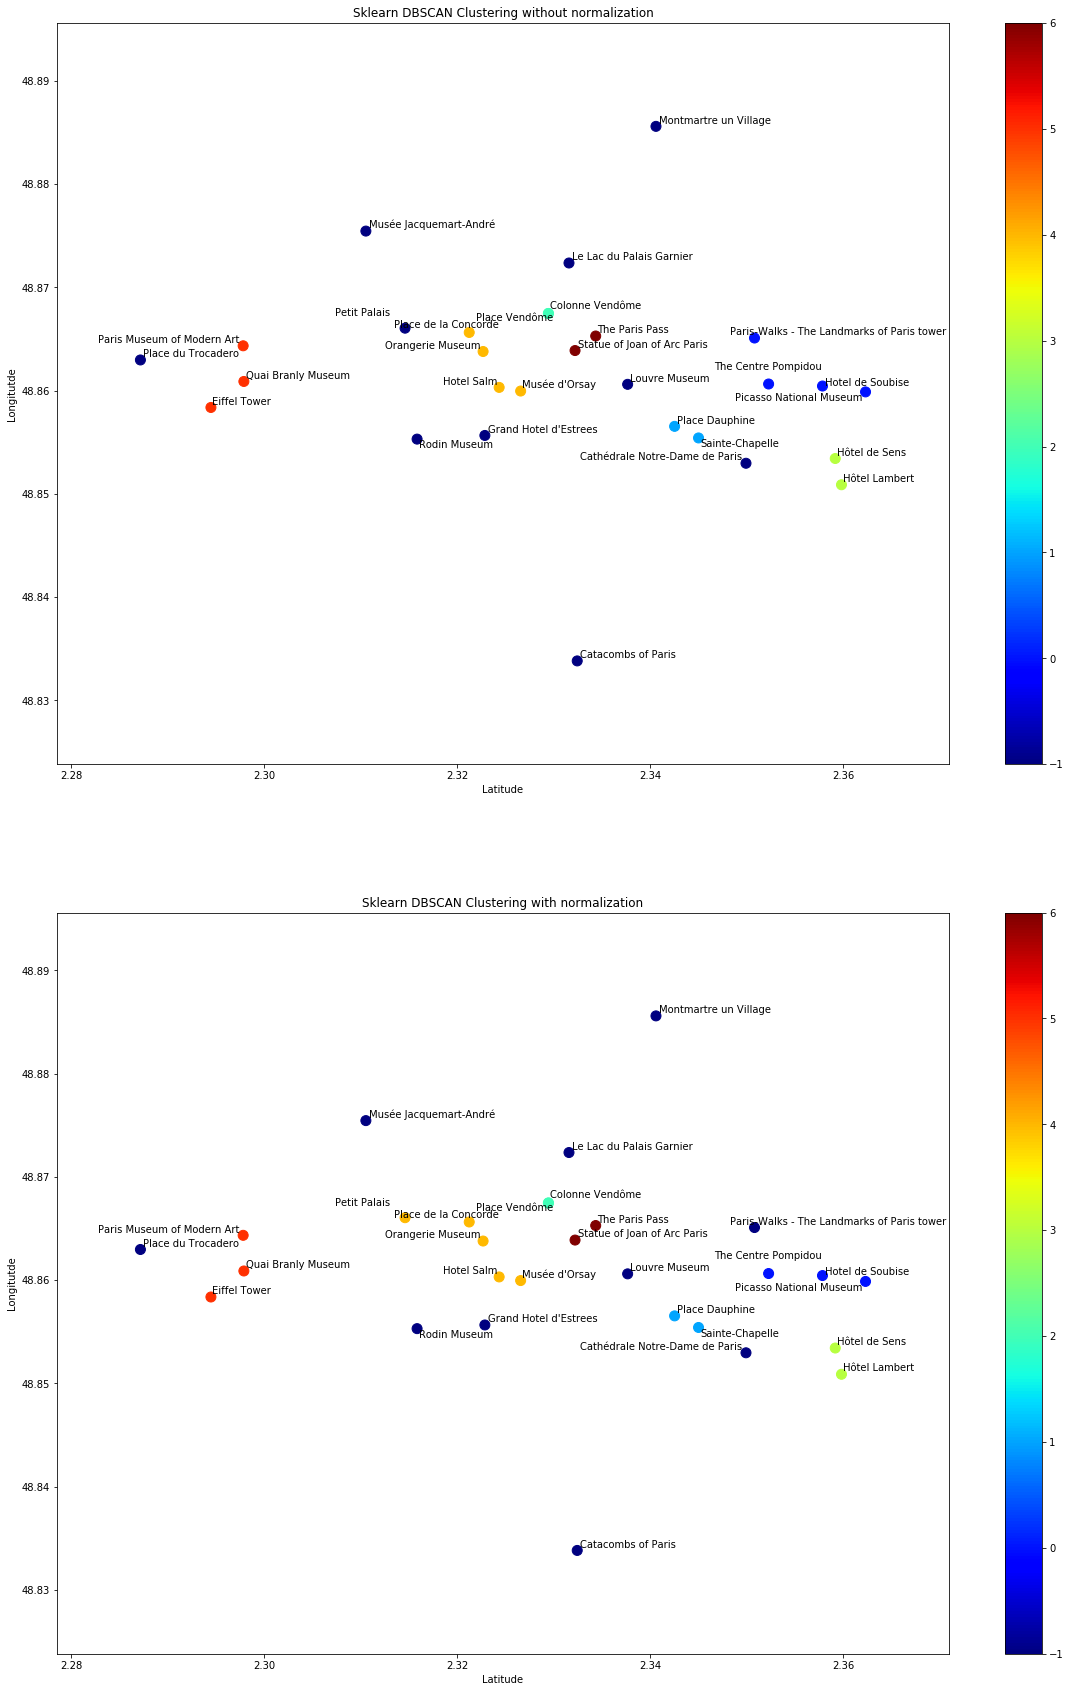

In [7]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
from sklearn.cluster import DBSCAN 
db = DBSCAN(eps=0.006,min_samples=2,n_jobs=40,metric='manhattan')
X = df[['Longitude','Latitude']].values
predictions = db.fit_predict(X) 
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(211)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('Sklearn DBSCAN Clustering without normalization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
texts = [ax.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']))
print()
df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
db = DBSCAN(eps=0.1,min_samples=2,n_jobs=100,metric='manhattan')
X = df[['Longitude','Latitude']].values
predictions = db.fit_predict(X) 
ax1 = fig.add_subplot(212)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('Sklearn DBSCAN Clustering with normalization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
texts = [ax1.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']))

# Analysis of sklearn's DBSCAN with manhattan

* There is a difference, however, by tweaking the eps value in both algorithm, they can be made to converge to the same value.
* Almost the same results as with using the harvesine distance.



# Sklearn's MeanShift

Snippet of dataframe without normlization:
    Latitude  Longitude                                       Place  Cluster
17  2.310532  48.875448                      Musée Jacquemart-André       -1
14  2.322672  48.863788                            Orangerie Museum        0
23  2.321236  48.865633                        Place de la Concorde        0
24  2.329432  48.867471                               Place Vendôme        0
16  2.314590  48.866048                                Petit Palais        0
15  2.315835  48.855307                                Rodin Museum        0
25  2.332197  48.863882                 Statue of Joan of Arc Paris        0
12  2.326561  48.859961                               Musée d'Orsay        0
21  2.334335  48.865290                              The Paris Pass        0
11  2.337644  48.860611                               Louvre Museum        0
7   2.324336  48.860313                                  Hotel Salm        0
5   2.329445  48.867473          

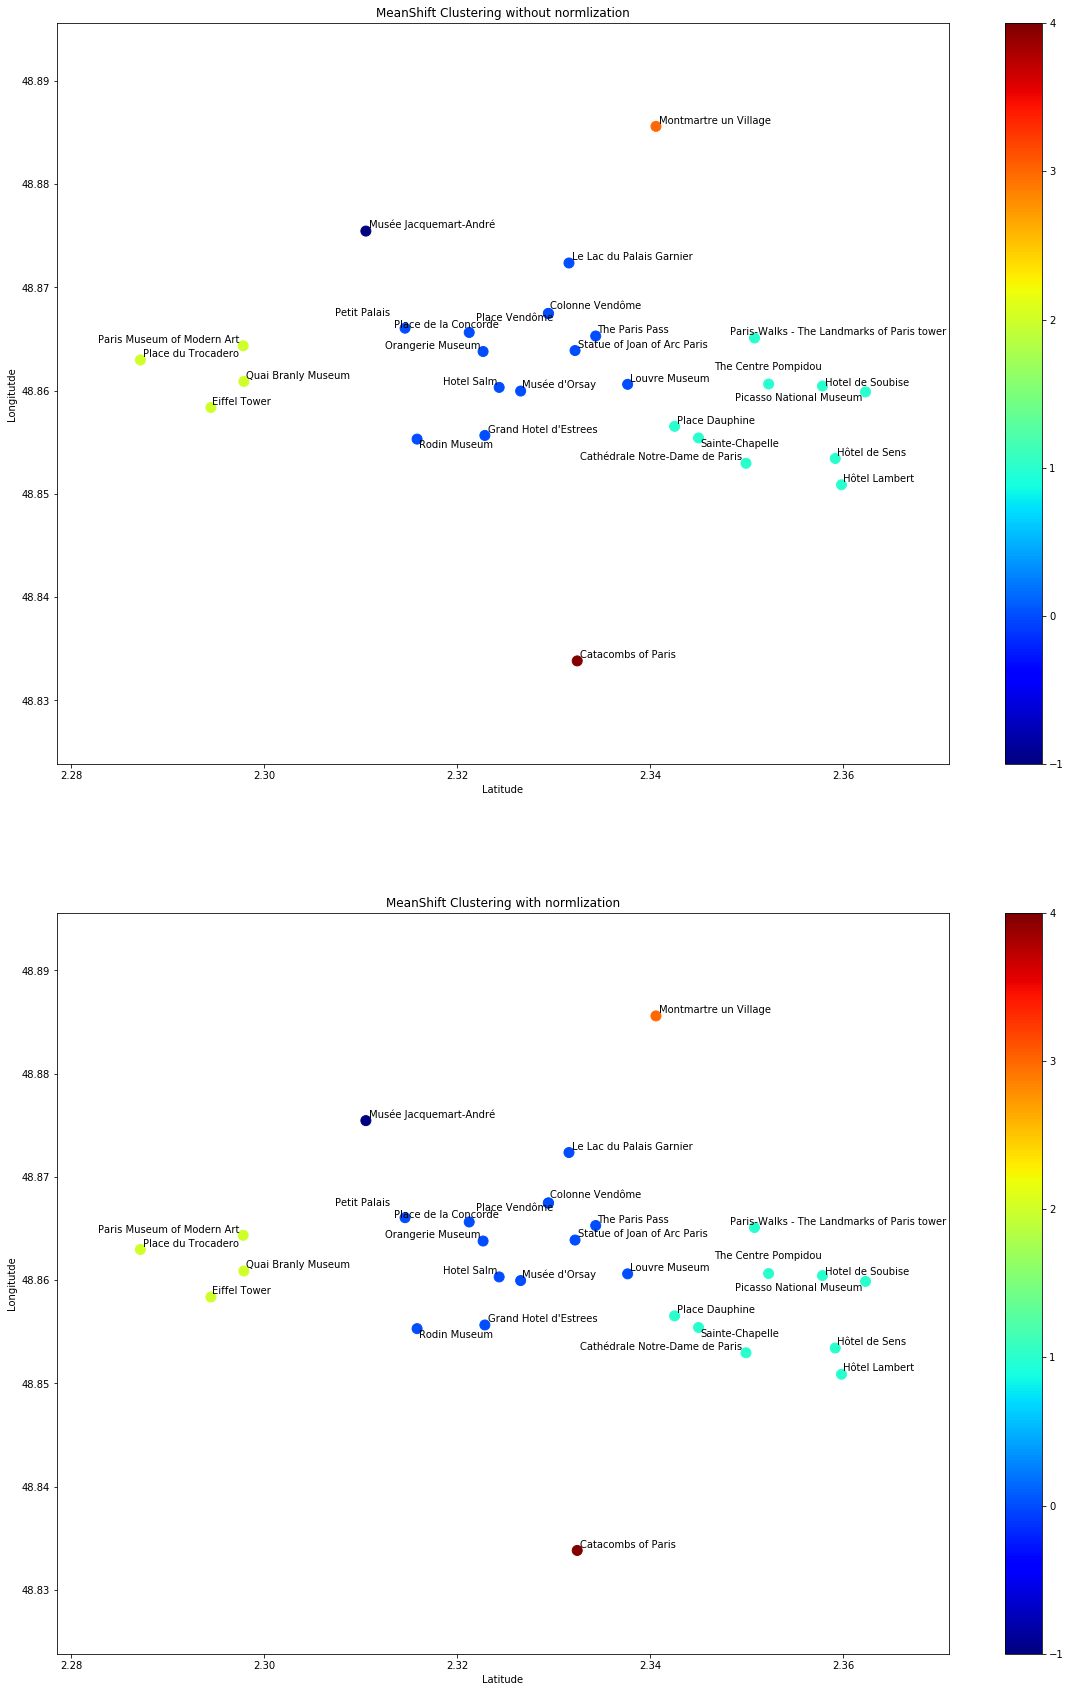

In [8]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
from sklearn.cluster import MeanShift 
ms = MeanShift(min_bin_freq =1,n_jobs=-1,cluster_all =False)
X = df[['Longitude','Latitude']].values
predictions = ms.fit_predict(X) 
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(211)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('MeanShift Clustering without normlization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
texts = [ax.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']))
print()

df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = ms.fit_predict(X) 
ax1 = fig.add_subplot(212)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('MeanShift Clustering with normlization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
texts = [ax1.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']))


# Analysis of sklearn's MeanShift

* No difference
* Clusters contain either too many or too little points.


# Sklearn's SpectralClustering

Snippet of dataframe without normlization:
    Latitude  Longitude                                       Place  Cluster
14  2.322672  48.863788                            Orangerie Museum        0
24  2.329432  48.867471                               Place Vendôme        0
23  2.321236  48.865633                        Place de la Concorde        0
21  2.334335  48.865290                              The Paris Pass        0
4   2.331569  48.872358                    Le Lac du Palais Garnier        0
5   2.329445  48.867473                             Colonne Vendôme        0
20  2.340579  48.885587                       Montmartre un Village        0
17  2.310532  48.875448                      Musée Jacquemart-André        0
16  2.314590  48.866048                                Petit Palais        0
18  2.297821  48.864342                  Paris Museum of Modern Art        1
15  2.315835  48.855307                                Rodin Museum        1
27  2.332422  48.833832          

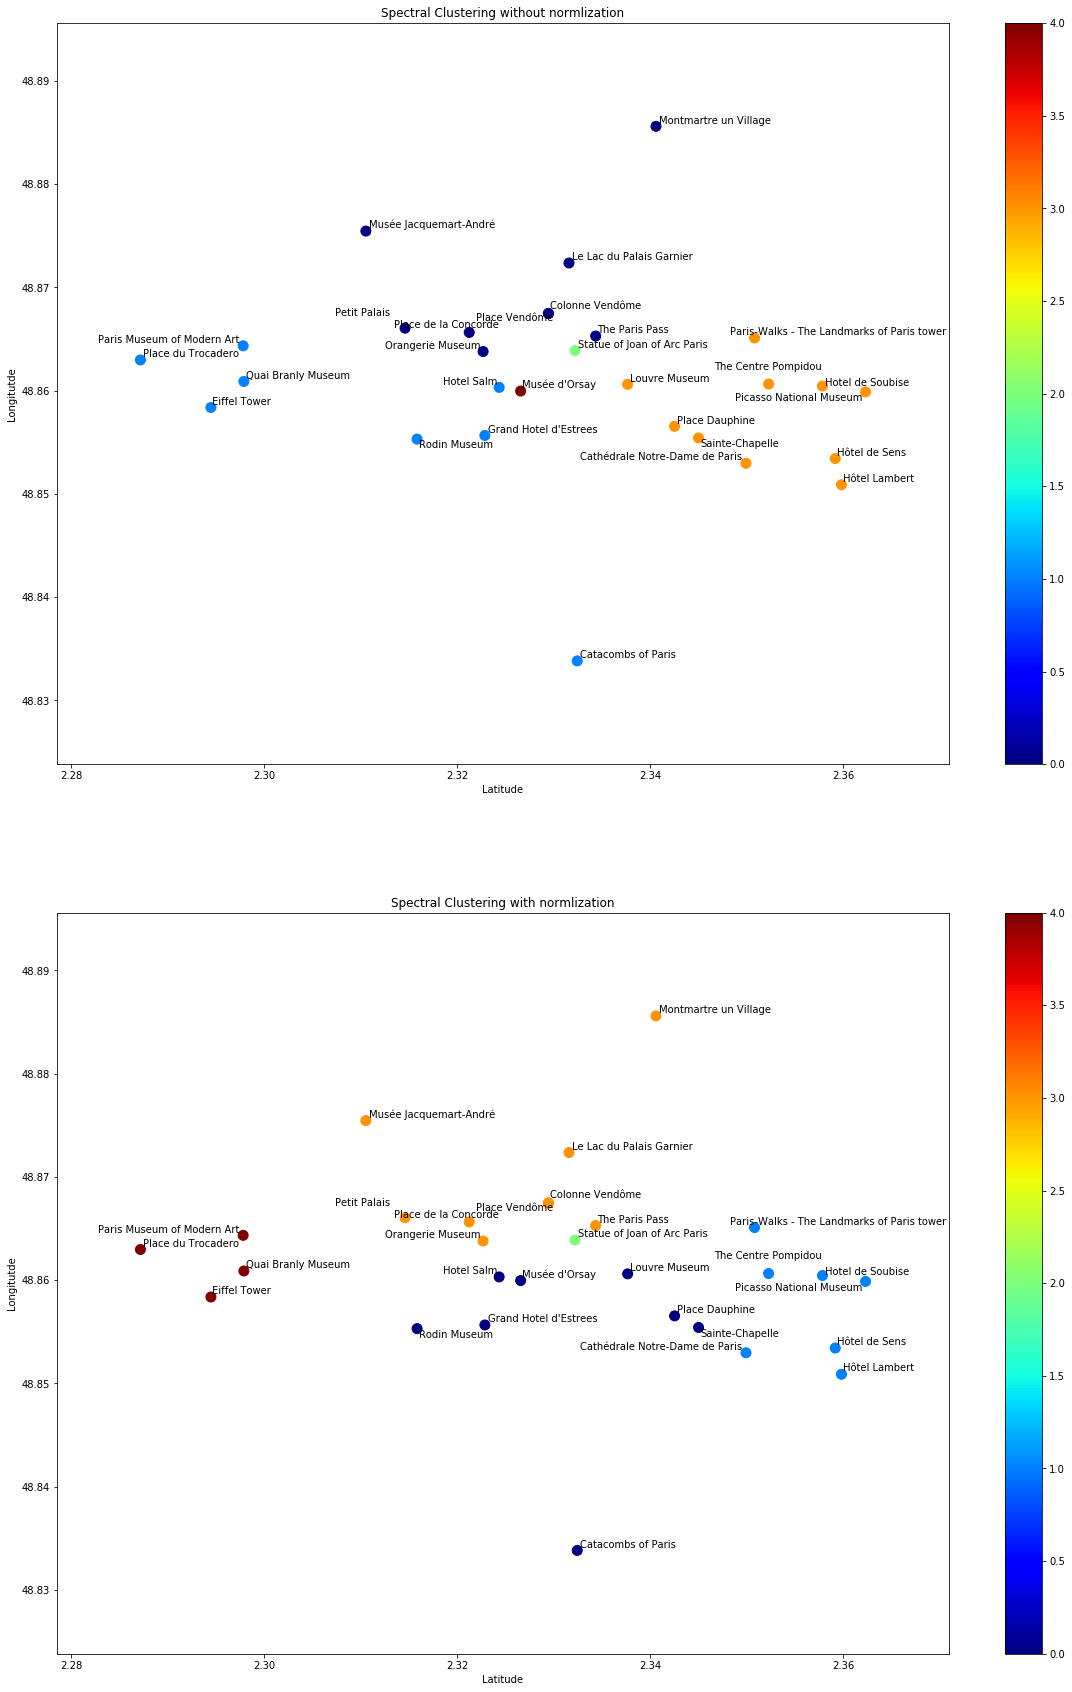

In [9]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
from sklearn.cluster import SpectralClustering 
sc = SpectralClustering(n_clusters =5,n_jobs=-1,n_init=40)
X = df[['Longitude','Latitude']].values
predictions = sc.fit_predict(X) 
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(211)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('Spectral Clustering without normlization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
texts = [ax.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']))
print()
df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = sc.fit_predict(X) 
ax1 = fig.add_subplot(212)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('Spectral Clustering with normlization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
#Uncomment the two following lines if you want to see the labels. Also increase the figsize!
texts = [ax1.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']))

# Analysis of sklearn's spectral clustering

* The normalized clustering is more cohesive.  


# Sklearn's AgglomerativeClustering

Snippet of dataframe without normlization:
    Latitude  Longitude                                       Place  Cluster
14  2.322672  48.863788                            Orangerie Museum        0
25  2.332197  48.863882                 Statue of Joan of Arc Paris        0
24  2.329432  48.867471                               Place Vendôme        0
23  2.321236  48.865633                        Place de la Concorde        0
4   2.331569  48.872358                    Le Lac du Palais Garnier        0
5   2.329445  48.867473                             Colonne Vendôme        0
21  2.334335  48.865290                              The Paris Pass        0
7   2.324336  48.860313                                  Hotel Salm        0
9   2.322857  48.855661                       Grand Hotel d'Estrees        0
17  2.310532  48.875448                      Musée Jacquemart-André        0
11  2.337644  48.860611                               Louvre Museum        0
12  2.326561  48.859961          

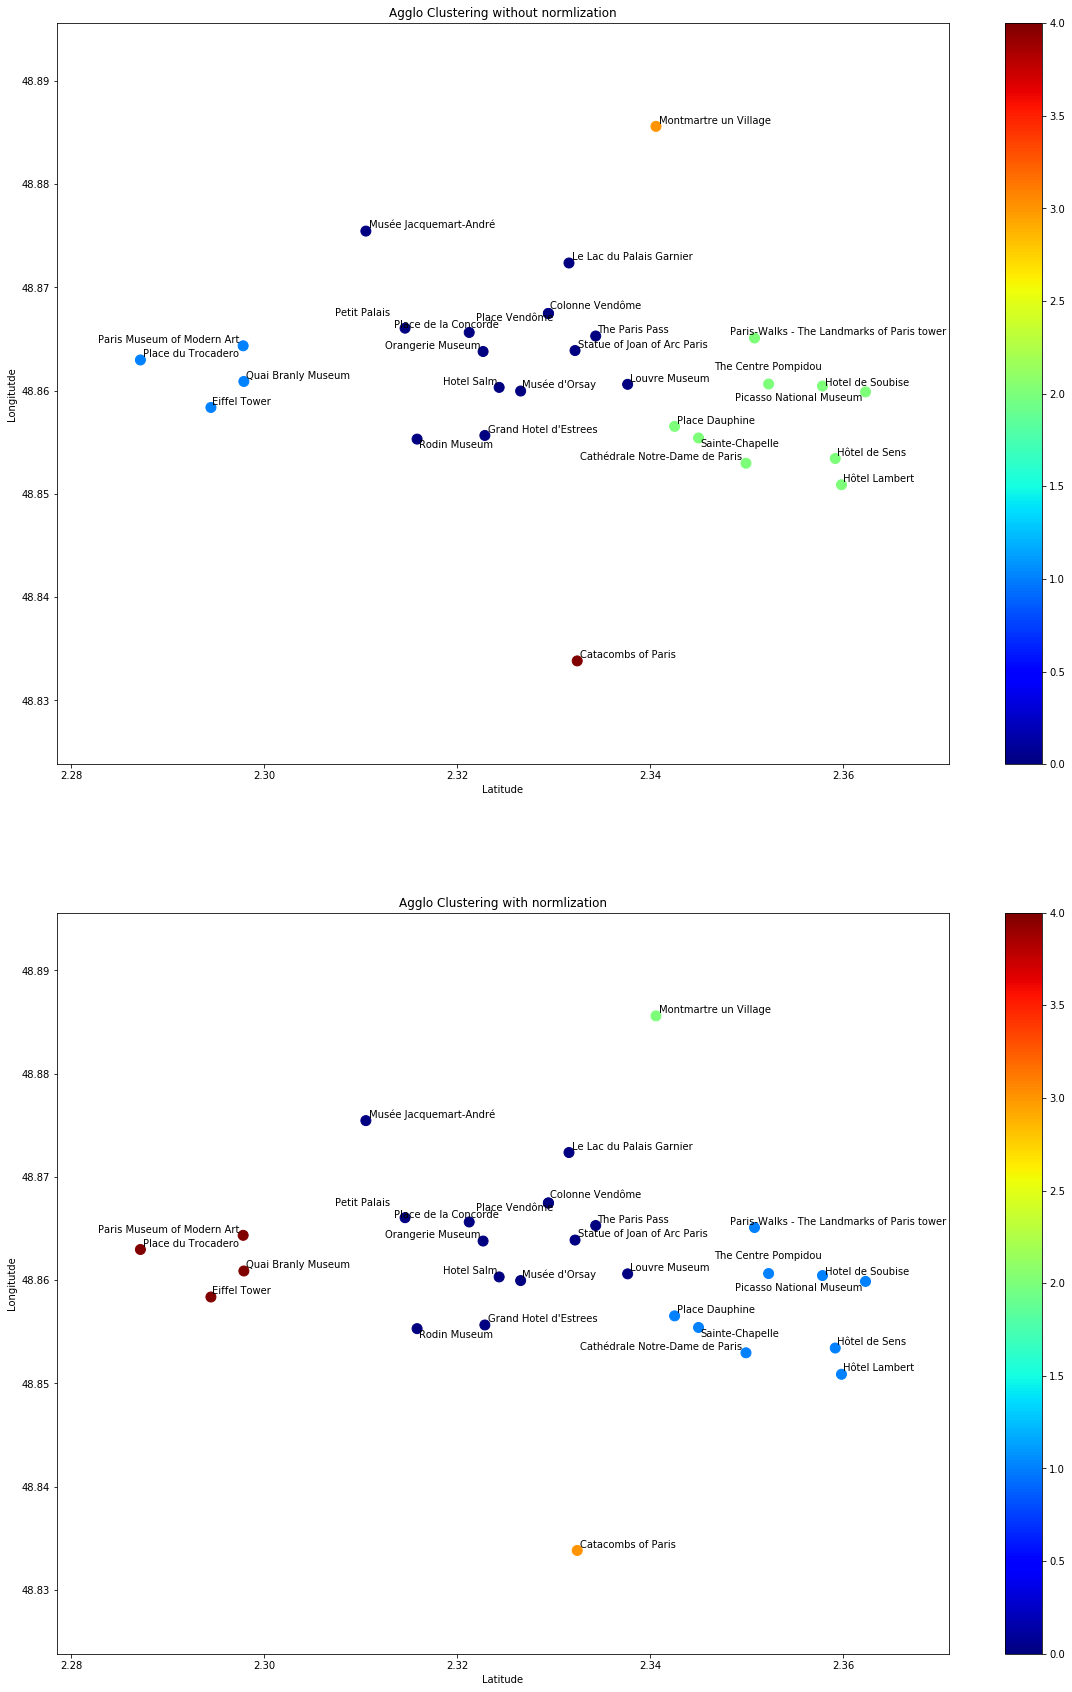

In [10]:
df['Latitude']=df_ct['Latitude']
df['Longitude']=df_ct['Longitude']
from sklearn.cluster import AgglomerativeClustering 
ac = AgglomerativeClustering(n_clusters =5,affinity='manhattan',linkage='average')
X = df[['Longitude','Latitude']].values
predictions = ac.fit_predict(X) 
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(211)
scatter = ax.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax.set_title('Agglo Clustering without normlization')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
texts = [ax.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe without normlization:")
print(df_ct.sort_values(by=['Cluster']))
print()

df['Latitude']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].max()-df['Latitude'].min())
df['Longitude']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].max()-df['Longitude'].min())
X = df[['Longitude','Latitude']].values
predictions = ac.fit_predict(X) 
ax1 = fig.add_subplot(212)
scatter = ax1.scatter(df_ct['Latitude'],df_ct['Longitude'],
                     c=predictions,s=100,cmap=plt.cm.get_cmap('jet'))
ax1.set_title('Agglo Clustering with normlization')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitutde')
plt.colorbar(scatter)
df_ct['Cluster']=predictions
texts = [ax1.text(df_ct['Latitude'][i], df_ct['Longitude'][i], df_ct['Place'][i], ha='center', va='center') for i in range(len(df_ct))]
adjust_text(texts) 
print("Snippet of dataframe with normlization:")
print(df_ct.sort_values(by=['Cluster']))


# Analysis of sklearn's agglomerative clustering

* Both look more or less the same with the same number of clusters.
* By increasing the number of clusters to 7, we get rid of the two noise points:


![title](7-clusters-agg-result.png)

![title](7-clusters-agg.png)

## Conclusion

# Normalized vs Un-normalized

* There doesn't seem to be a noticeable difference between mean normalization and no normalization. Most of the time, the differences are due to initial conditions, and different hyperparameter selection. However, by tweaking the hyperparamters and increasing the number of jobs, the normalized and un-normalizaed versions converge to the same clusters.

# Concerning the algorithms

* Since I am organizing 5 days in Paris. I have tried obtaining 5 clusters from each algorithm.

## Kmeans 
* I set the number of clusters to 7 to have 2 'noise-clusters'. This is a disadvantage for this algorithm: the value of k. Another way to solve this problem would be to remove this points altogether.

## DBSCAN (both)
* Harvesine/manhattan (which takes into account the curvature) provided a good balance between cluster cohesion and the number of points in each cluster

## MeanShift
* Provided clusters similar to the 5-cluster version of k-means. There simply is too many or too little points in 1 cluster.

## Spectral
* General results are cohesive but since each point must belong to a cluster, we observe outliers affecting some of the clusters.

## Agglomerative
* Has the same problem as k-means, where setting the number of clusters to 7 solves the noisy points' problem. After that, the clustering is quite sensible.

# Which one will I use?

* I will inspire my tour using sklearn's dbscan.

